In [1]:
import nltk 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split


In [3]:
df=pd.read_csv("FakeNewsNet.csv")
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


<Axes: xlabel='real', ylabel='count'>

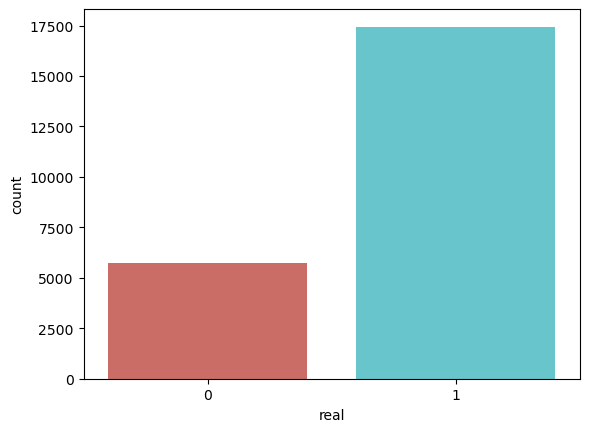

In [4]:
sns.countplot(x='real',data=df,palette='hls')

In [5]:

df=df.dropna()
print(df.isnull().sum())


title            0
news_url         0
source_domain    0
tweet_num        0
real             0
dtype: int64


In [6]:

# Defining the preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(stemmed_tokens)

# Applying the preprocessing function to the text column
df['title'] = df['title'].apply(preprocess_text)


In [ ]:
df=df.dropna()

# Defining the preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(stemmed_tokens)

# Applying the preprocessing function to the text column
df['title'] = df['title'].apply(preprocess_text)

In [7]:
import re

def preprocess_url(url):
    url = re.sub(r'^https?:\/\/', '', url)
    url = re.sub(r'^www\.', '', url)
    url = re.sub(r'\/$', '', url)
    url = re.sub(r'\d', '', url)
    
    return url

df['news_url'] = df['news_url'].apply(preprocess_url)


In [8]:
# Combine the text columns into a single column to vectorize
df['text'] = df['title'] + ' ' + df['news_url'] + ' ' + df['source_domain']

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(df['text'])

y_train = df['real']


In [9]:
# Create an XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
importances = model.feature_importances_
feature_names = vectorizer.get_feature_names_out()
features_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
features_df = features_df.sort_values(by='Importance', ascending=False)
print(features_df)

                      Feature  Importance
11926           hollywoodlife    0.025144
19735             radaronline    0.018658
11929                    holm    0.016197
12419                    imdb    0.015508
18716                    pitt    0.014365
...                       ...         ...
9254   familyandrelationships    0.000000
9253   family_of_barack_obama    0.000000
9252                   family    0.000000
9251                 families    0.000000
27537                    私のコト    0.000000

[27538 rows x 2 columns]


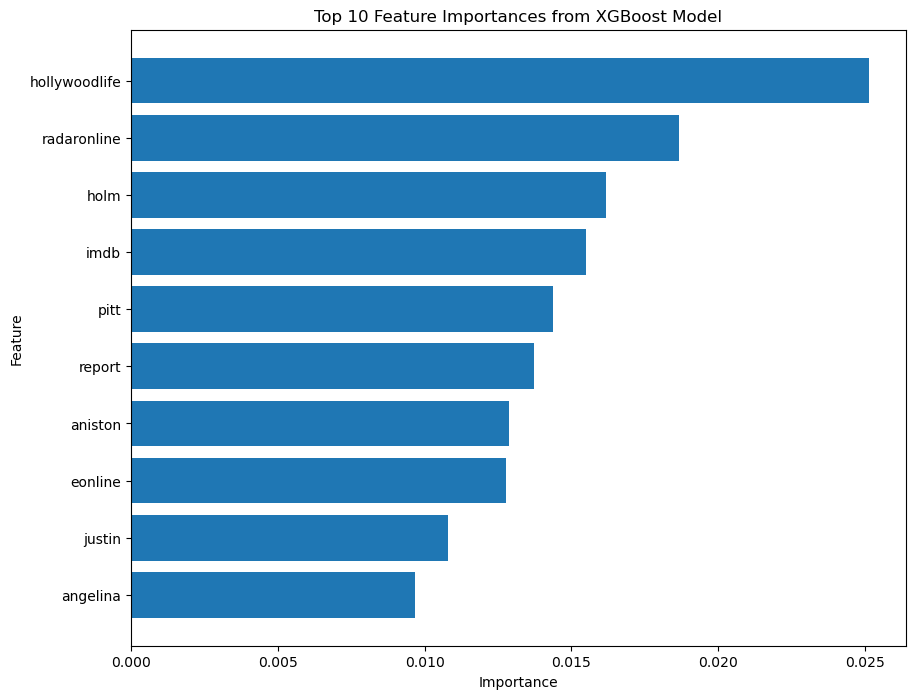

In [10]:
import matplotlib.pyplot as plt

top_features_df = features_df.head(10) 

plt.figure(figsize=(10, 8))
plt.barh(top_features_df['Feature'], top_features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances from XGBoost Model')
plt.gca().invert_yaxis()  
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

# Split the data into 80% training and 20% testing
X_train1, X_temp1, y_train1, y_temp1 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Further split the test data into 50% test and 50% validation (which makes it 10% of the original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp1, y_temp1, test_size=0.5, random_state=42)

# Create a Logistic Regression modelA
logreg = LogisticRegression(max_iter=50000)
logreg.fit(X_train1, y_train1)
y_val_pred = logreg.predict(X_val)
y_test_pred = logreg.predict(X_test)


print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred))
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred))


Validation Accuracy:  0.8666375163970267
Test Accuracy:  0.8679492785308264


In [12]:
print(classification_report(y_val, y_val_pred))
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_val, y_val_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.52      0.66       565
           1       0.86      0.98      0.92      1722

    accuracy                           0.87      2287
   macro avg       0.88      0.75      0.79      2287
weighted avg       0.87      0.87      0.85      2287

              precision    recall  f1-score   support

           0       0.86      0.53      0.65       540
           1       0.87      0.97      0.92      1747

    accuracy                           0.87      2287
   macro avg       0.86      0.75      0.79      2287
weighted avg       0.87      0.87      0.86      2287

[[ 291  274]
 [  31 1691]]
[[ 284  256]
 [  46 1701]]


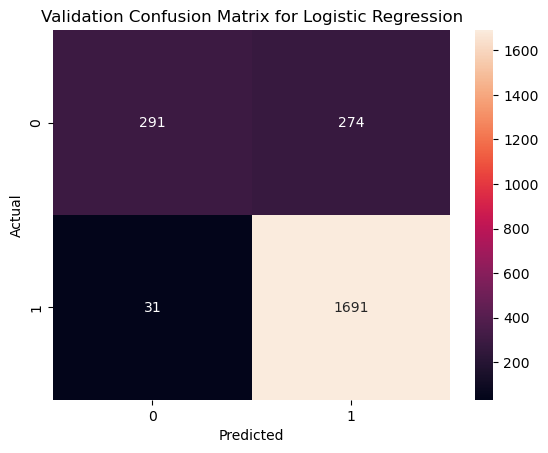

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix for Logistic Regression')
plt.show()

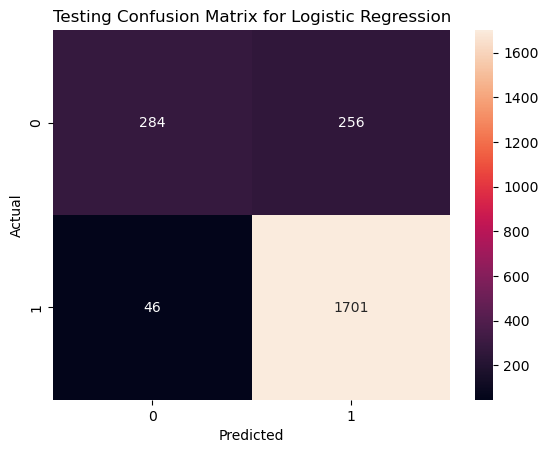

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Testing Confusion Matrix for Logistic Regression')
plt.show()

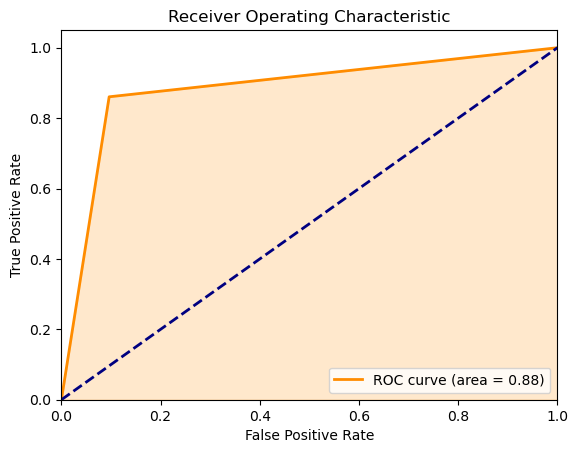

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val_pred, y_val)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
plt.legend(loc="lower right")
plt.show()

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf.fit(X_train1, y_train1)

y_pred_valid_rf = rf.predict(X_val)
y_pred_test_rf = rf.predict(X_test)

print("Validation Accuracy: ", accuracy_score(y_val, y_pred_valid_rf))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_test_rf))

Validation Accuracy:  0.8648885002186271
Test Accuracy:  0.8675120244862266


In [17]:
print(classification_report(y_val, y_pred_valid_rf))
print(classification_report(y_test, y_pred_test_rf))
print(confusion_matrix(y_val, y_pred_valid_rf))
print(confusion_matrix(y_test, y_pred_test_rf))

              precision    recall  f1-score   support

           0       0.87      0.53      0.66       565
           1       0.86      0.97      0.92      1722

    accuracy                           0.86      2287
   macro avg       0.87      0.75      0.79      2287
weighted avg       0.87      0.86      0.85      2287

              precision    recall  f1-score   support

           0       0.83      0.56      0.66       540
           1       0.88      0.96      0.92      1747

    accuracy                           0.87      2287
   macro avg       0.85      0.76      0.79      2287
weighted avg       0.86      0.87      0.86      2287

[[ 302  263]
 [  46 1676]]
[[ 300  240]
 [  63 1684]]


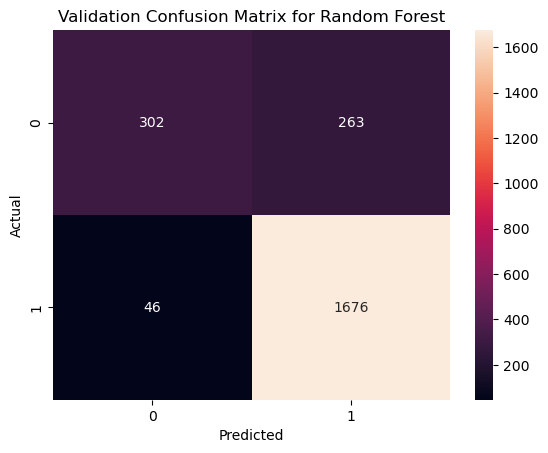

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_rf = confusion_matrix(y_val, y_pred_valid_rf)
sns.heatmap(cm_rf, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix for Random Forest')
plt.show()

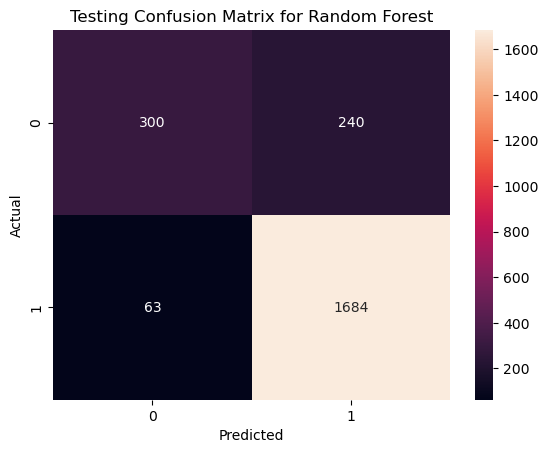

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_rf = confusion_matrix(y_test,  y_pred_test_rf)
sns.heatmap(cm_rf, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Testing Confusion Matrix for Random Forest')
plt.show()

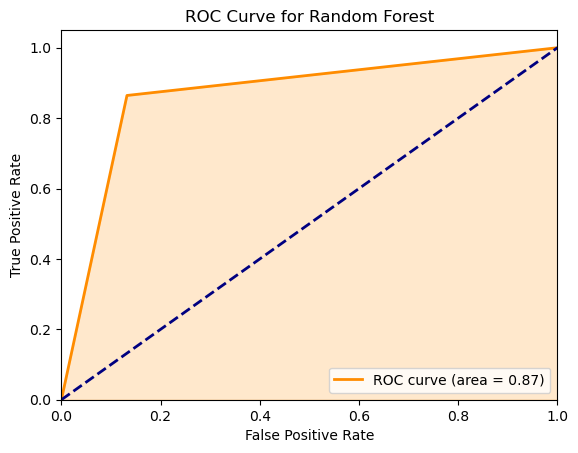

In [20]:
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_pred_valid_rf, y_val)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.fill_between(fpr_rf, tpr_rf, alpha=0.2, color='darkorange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create an SVM classifier
svm = SVC()

# Fit the classifier to the training data
svm.fit(X_train1, y_train1)

y_pred_valid_svm = svm.predict(X_val)
y_pred_test_svm = svm.predict(X_test)

print("Validation Accuracy: ", accuracy_score(y_val, y_pred_valid_svm)) 
print("Test Accuracy: ", accuracy_score(y_test, y_pred_test_svm)) 


Validation Accuracy:  0.8740708351552252
Test Accuracy:  0.8731963270660253


In [22]:
print(classification_report(y_val, y_pred_valid_svm))
print(classification_report(y_test, y_pred_test_svm))
print(confusion_matrix(y_val, y_pred_valid_svm))
print(confusion_matrix(y_test, y_pred_test_svm))

              precision    recall  f1-score   support

           0       0.91      0.54      0.68       565
           1       0.87      0.98      0.92      1722

    accuracy                           0.87      2287
   macro avg       0.89      0.76      0.80      2287
weighted avg       0.88      0.87      0.86      2287

              precision    recall  f1-score   support

           0       0.87      0.54      0.67       540
           1       0.87      0.98      0.92      1747

    accuracy                           0.87      2287
   macro avg       0.87      0.76      0.79      2287
weighted avg       0.87      0.87      0.86      2287

[[ 306  259]
 [  29 1693]]
[[ 292  248]
 [  42 1705]]


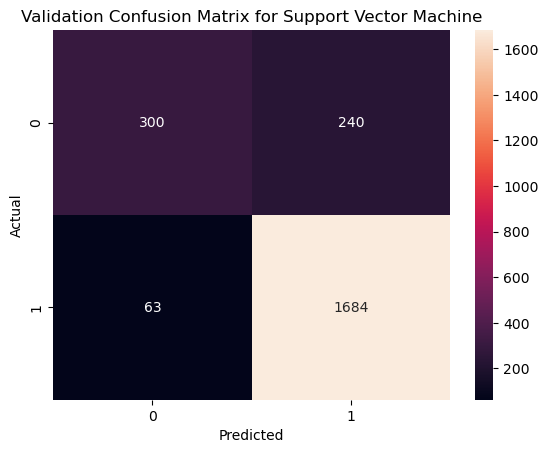

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_svm = confusion_matrix(y_val, y_pred_valid_svm)
sns.heatmap(cm_rf, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix for Support Vector Machine')
plt.show()

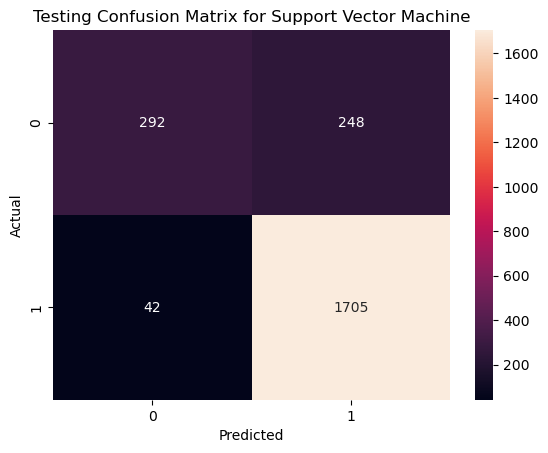

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_svm = confusion_matrix(y_test,  y_pred_test_svm)
sns.heatmap(cm_svm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Testing Confusion Matrix for Support Vector Machine')
plt.show()

<Axes: xlabel='Kernel', ylabel='Accuracy'>

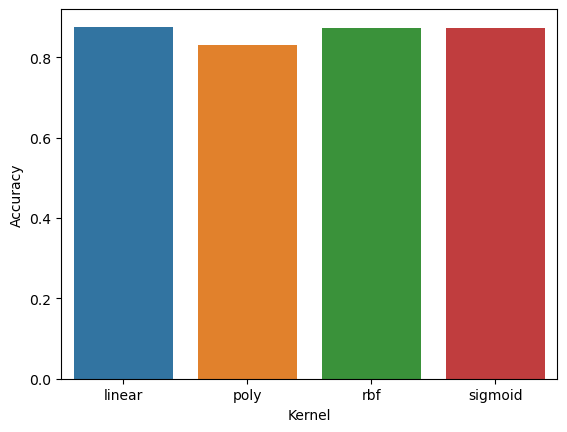

In [25]:
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# List of kernels to test
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
accuracies = []

# Train an SVM with each kernel and calculate accuracy
for kernel in kernels:
    model = svm.SVC(kernel=kernel)
    model.fit(X_train1, y_train1)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

df = pd.DataFrame({'Kernel': kernels, 'Accuracy': accuracies})
sns.barplot(x='Kernel', y='Accuracy', data=df)

In [80]:
print(kernels,accuracies)

['linear', 'poly', 'rbf', 'sigmoid'] [0.8762571053782248, 0.8307826847398339, 0.8731963270660253, 0.8740708351552252]


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

cart = DecisionTreeClassifier(random_state=42)
cart.fit(X_train1, y_train1)

y_pred_valid_cart = cart.predict(X_val)
y_pred_test_cart = cart.predict(X_test)

print("Validation Accuracy: ", accuracy_score(y_val, y_pred_valid_cart))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_test_cart))

Validation Accuracy:  0.8233493659816353
Test Accuracy:  0.8216003498032357


In [27]:
print(classification_report(y_val, y_pred_valid_cart))
print(classification_report(y_test, y_pred_test_cart))
print(confusion_matrix(y_val, y_pred_valid_cart))
print(confusion_matrix(y_test, y_pred_test_cart))

              precision    recall  f1-score   support

           0       0.65      0.61      0.63       565
           1       0.87      0.89      0.88      1722

    accuracy                           0.82      2287
   macro avg       0.76      0.75      0.76      2287
weighted avg       0.82      0.82      0.82      2287

              precision    recall  f1-score   support

           0       0.63      0.60      0.62       540
           1       0.88      0.89      0.88      1747

    accuracy                           0.82      2287
   macro avg       0.75      0.75      0.75      2287
weighted avg       0.82      0.82      0.82      2287

[[ 342  223]
 [ 181 1541]]
[[ 326  214]
 [ 194 1553]]


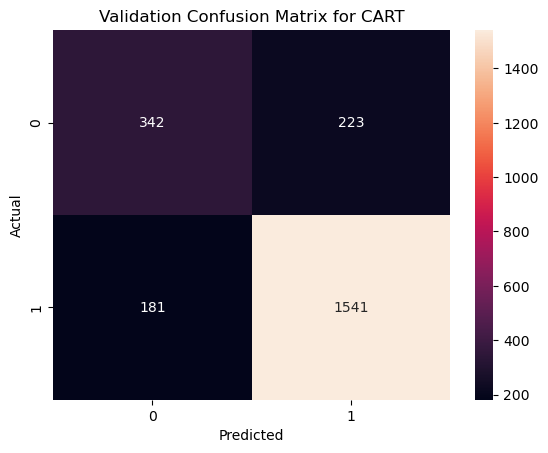

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_cart = confusion_matrix(y_val, y_pred_valid_cart)
sns.heatmap(cm_cart, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix for CART')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_cart = confusion_matrix(y_val, y_pred_valid_cart)
sns.heatmap(cm_cart, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix for CART')
plt.show()

cm_cart = confusion_matrix(y_test, y_pred_test_cart)
sns.heatmap(cm_cart, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Testing Confusion Matrix for CART')
plt.show()

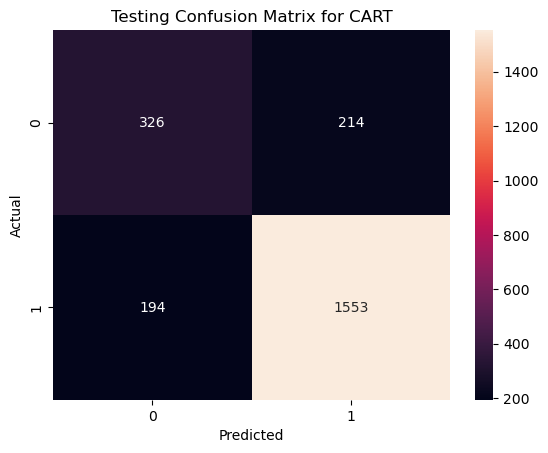

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_cart = confusion_matrix(y_test, y_pred_test_cart)
sns.heatmap(cm_cart, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Testing Confusion Matrix for CART')
plt.show()

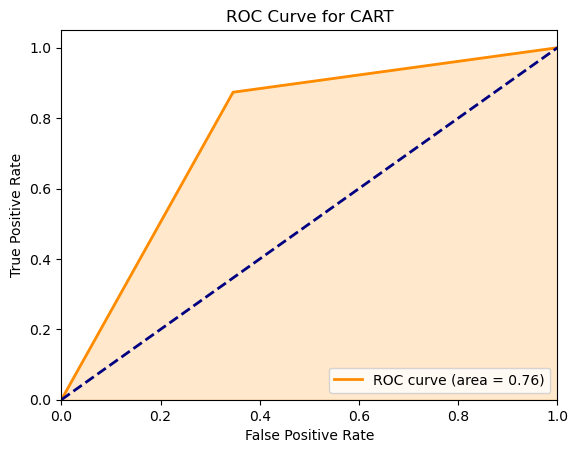

In [33]:
from sklearn.metrics import roc_curve, auc

fpr_cart, tpr_cart, thresholds_cart = roc_curve(y_pred_valid_cart, y_val)
roc_auc_cart = auc(fpr_cart, tpr_cart)

plt.figure()
plt.plot(fpr_cart, tpr_cart, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cart)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.fill_between(fpr_cart, tpr_cart, alpha=0.2, color='darkorange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CART')
plt.legend(loc="lower right")
plt.show()

In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Create an NNET model
nnet = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                     random_state=42)
# Fit the model
nnet.fit(X_train1, y_train1)

y_val_pred_nnet = nnet.predict(X_val)
y_test_pred_nnet = nnet.predict(X_test)

# Print the validation and test accuracies
print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred_nnet))
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred_nnet))
 

Validation Accuracy:  0.8543944031482291
Test Accuracy:  0.8522081329252296


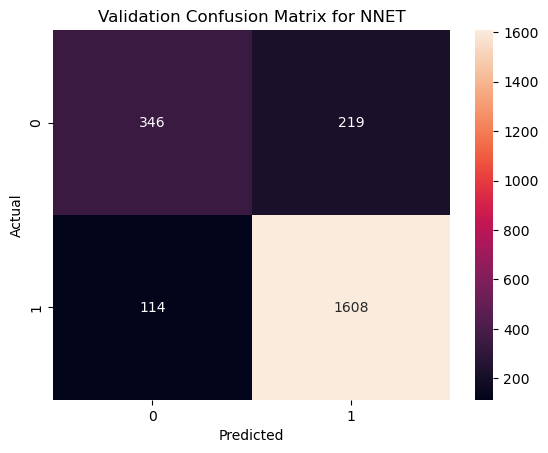

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_nnet = confusion_matrix(y_val, y_val_pred_nnet)
sns.heatmap(cm_nnet, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix for NNET')
plt.show()

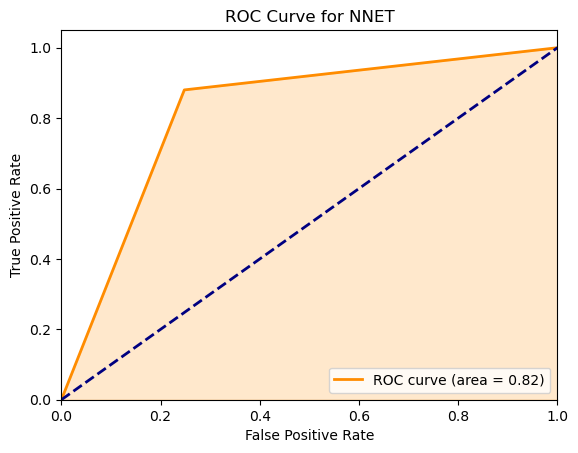

In [44]:
from sklearn.metrics import roc_curve, auc

fpr_nnet, tpr_nnet, thresholds_nnet = roc_curve(y_val_pred_nnet, y_val)
roc_auc_nnet = auc(fpr_nnet, tpr_nnet)

plt.figure()
plt.plot(fpr_nnet, tpr_nnet, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_nnet)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.fill_between(fpr_nnet, tpr_nnet, alpha=0.2, color='darkorange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NNET')
plt.legend(loc="lower right")
plt.show()

In [49]:
print(accuracies)

[0.8666375163970267, 0.8648885002186271, 0.8740708351552252, 0.8233493659816353, 0.8543944031482291]


In [69]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# Assuming X_train1, y_train1 are your training data and labels
# Create a simple neural network
model = Sequential()
model.add(Dense(8, input_dim=27538, activation='relu'))  # Corrected input shape
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Updated output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model and get the history
history=model.fit(X_train1, y_train1, validation_data=(X_val, y_val), epochs=10, batch_size=10, verbose=0)

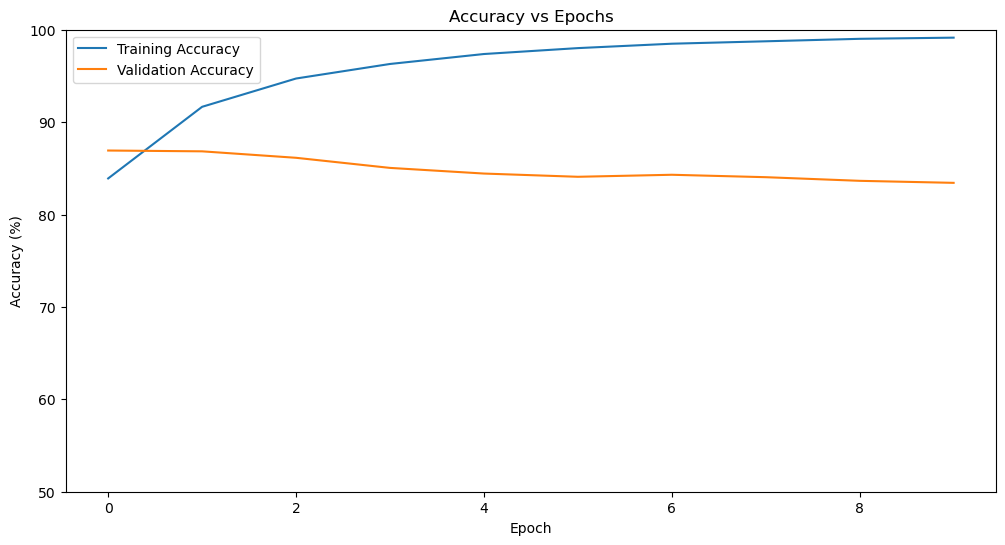

In [70]:
plt.figure(figsize=(12, 6))
plt.plot([i*100 for i in history.history['accuracy']], label='Training Accuracy')
plt.plot([i*100 for i in history.history['val_accuracy']], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy (%)')  # Update label to reflect percentage
plt.xlabel('Epoch')
plt.ylim([50,100])
plt.legend()
plt.show()


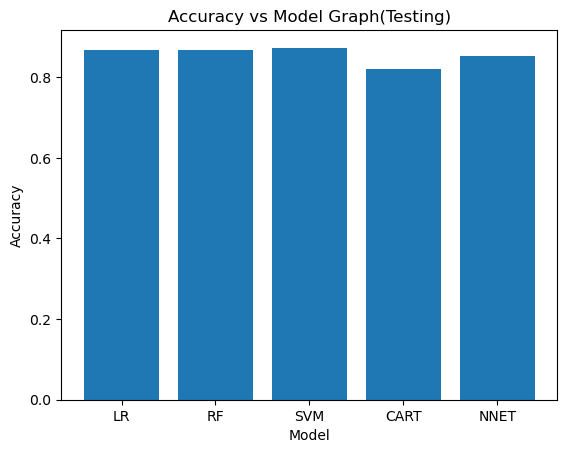

In [71]:
import matplotlib.pyplot as plt

model_names = ['LR', 'RF', 'SVM', 'CART', 'NNET']

lr_acc=accuracy_score(y_test, y_test_pred)
rf_acc=accuracy_score(y_test, y_pred_test_rf)
svm_acc=accuracy_score(y_test, y_pred_test_svm)
cart_acc=accuracy_score(y_test, y_pred_test_cart)
nnet_acc=accuracy_score(y_test, y_test_pred_nnet)

accuracies = [lr_acc,rf_acc,svm_acc,cart_acc,nnet_acc]

plt.bar(model_names, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Model Graph(Testing)')
plt.show()

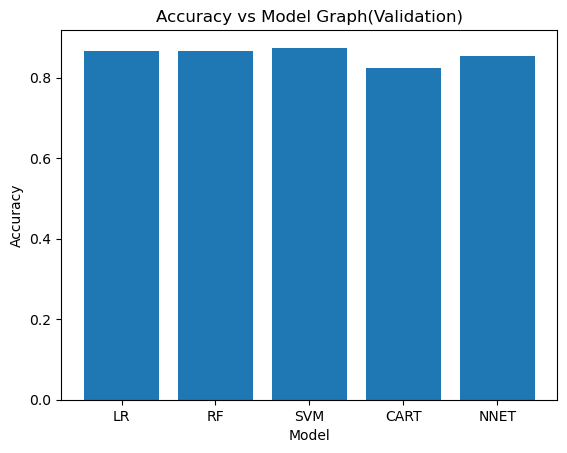

In [72]:
import matplotlib.pyplot as plt

model_names = ['LR', 'RF', 'SVM', 'CART', 'NNET']

lr_acc=accuracy_score(y_val, y_val_pred)
rf_acc=accuracy_score(y_val, y_pred_valid_rf)
svm_acc=accuracy_score(y_val, y_pred_valid_svm)
cart_acc=accuracy_score(y_val, y_pred_valid_cart)
nnet_acc=accuracy_score(y_val, y_val_pred_nnet)

accuracies = [lr_acc,rf_acc,svm_acc,cart_acc,nnet_acc]

plt.bar(model_names, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Model Graph(Validation)')
plt.show()